This notebook is to create the model for BERT-Single

Please ensure that your **runtime type** is set to **TPU**

Runtime > change runtime type > TPU


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install -r /path/to/BERT-ABSA/requirements.txt

     |████████████████████████████████| 2.1MB 6.2MB/s 
     |████████████████████████████████| 3.3MB 26.9MB/s 
     |████████████████████████████████| 901kB 42.7MB/s 


In [4]:
!pip install transformers==3

     |████████████████████████████████| 757kB 6.4MB/s 
     |████████████████████████████████| 3.0MB 11.1MB/s 
     |████████████████████████████████| 1.2MB 43.9MB/s 
  Found existing installation: tokenizers 0.10.2
    Uninstalling tokenizers-0.10.2:
      Successfully uninstalled tokenizers-0.10.2
  Found existing installation: transformers 4.5.1
    Uninstalling transformers-4.5.1:
      Successfully uninstalled transformers-4.5.1


# Installations of libraries and declarations of TPU

In [5]:
import os
import json
import numpy as np

!pip install tensorflow_addons
import tensorflow as tf
# from tensorflow.keras.layers import Dense, Embedding, Input, Flatten, Concatenate
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split

from transformers import BertTokenizer, TFBertModel, BertConfig
from transformers import *

     |████████████████████████████████| 706kB 5.3MB/s 


In [6]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


Running on TPU  grpc://10.11.115.82:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.11.115.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.11.115.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Data Preprocessing

This is to prep the data for bert-single classification

In [7]:
def pad_and_truncate(sequence, maxlen, dtype='int64', padding='post', truncating='post', value=0):
    x = (np.ones(maxlen) * value).astype(dtype)
    if truncating == 'pre':
        trunc = sequence[-maxlen:]
    else:
        trunc = sequence[:maxlen]
    trunc = np.asarray(trunc, dtype=dtype)
    if padding == 'post':
        x[:len(trunc)] = trunc
    else:
        x[-len(trunc):] = trunc
    return x

def get_dataset(data_path, tokenizer, aspect):

    with open(data_path) as f:
        json_data = json.load(f)

    bs, bsam, bsid, p = [], [], [], [] 
    polarity_dict = json_data["polarity_library"]
    for sentence in json_data["data"]:

        text = sentence['text'].lower()
        cat_arr = sentence["categories"]

        text_indices = tokenizer.text_to_sequence(text)
        text_indices = pad_and_truncate(text_indices, tokenizer.max_seq_len)
        text_len = np.sum(text_indices != 0)

        for cat in cat_arr:

          if cat['category'] != aspect:
            continue

          polarity = cat['polarity_id']
          polarity = int(polarity) + 1

          # if task_name != 'bert-nli-b' and task_name != 'bert-qab':

          # Bert text----------------------------------------------------------------------------------------------
          #bert single
          bert_single = tokenizer.text_to_sequence(text)
          bert_single_indices = pad_and_truncate(bert_single, tokenizer.max_seq_len)

          # token_type_ids----------------------------------------------------------------------------------------------
          # Segment token indices to indicate first and second portions of the inputs. Indices are selected in [0, 1]:
          #bert single
          bert_single_indices_token = [0] * text_len
          bert_single_indices_token = pad_and_truncate(bert_single_indices_token, tokenizer.max_seq_len)

          # attention_mask----------------------------------------------------------------------------------------------
          #bert-single
          bert_single_attention_mask = [1] * (text_len)
          bert_single_attention_mask = pad_and_truncate(bert_single_attention_mask, tokenizer.max_seq_len)


          bs.append(bert_single_indices)
          bsam.append(bert_single_attention_mask)
          bsid.append(bert_single_indices_token)
          p.append(polarity)

    return {
            'bert_single': bs,
            'bert_single_attention_mask': bsam,
            'bert_single_token_id': bsid,
            'polarity': p
        }


In [8]:
class Tokeniser:
  def __init__(self, max_seq_len):
      BERT_PRETRAINED_NAME = 'bert-base-uncased'
      self.tokeniser = BertTokenizer.from_pretrained(BERT_PRETRAINED_NAME)
      self.max_seq_len = max_seq_len

  def text_to_sequence(self, text, add_special_tokens=True):
      sequence = self.tokeniser.encode(text, add_special_tokens=add_special_tokens) # max_length=self.max_seq_len, truncation=truncate, padding=padding
      if len(sequence) == 0:
          sequence = [0]
      return sequence

# Semeval dataset WITHOUT CONFLICT sentiment

None, Negative, Neutral, Positive

In [13]:
BERT_PRETRAINED_NAME = 'bert-base-uncased'
MAX_SEQ_LEN = 128
TRAIN_PATH='/path/to/BERT-ABSA/datasets/json_without_conflict/Restaurants_Train.json'
TEST_PATH='/path/to/BERT-ABSA/datasets/json_without_conflict/Restaurants_Test.json'
BERT_PRETRAINED_NAME = 'bert-base-uncased'
ASPECT_LIBRARY = ["service", "food", "anecdotes/miscellaneous", "price", "ambience" ]
EPOCH = 50
LR = 2e-5
BATCH_SIZE = 24 * strategy.num_replicas_in_sync
tokenizer = Tokeniser(MAX_SEQ_LEN)

In [14]:
final_y_predict = {}
final_y_test = {}

In [15]:
for predict in final_y_predict:
  print(predict)

{0: 3.4908256880733943, 1: 38.05, 2: 2.3487654320987654, 3: 0.306607574536664}


- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training for aspect:  service
Epoch 1/50
15/15 [==============================] - 92s 858ms/step - loss: 1.3378 - accuracy: 0.1326 - val_loss: 1.2640 - val_accuracy: 0.2396
Epoch 2/50
15/15 [==============================] - 48s 209ms/step - loss: 1.3798 - accuracy: 0.3876 - val_loss: 1.1850 - val_accuracy: 0.4362
Epoch 3/50
15/15 [==============================] - 3s 208ms/step - loss: 1.3484 - accuracy: 0.4659 - val_loss: 1.1878 - val_accuracy: 0.4219
Epoch 4/50
15/15 [==============================] - 3s 209ms/step - loss: 1.3944 - accuracy: 0.4378 - val_loss: 1.2428 - val_accuracy: 0.2969
Epoch 5/50
15/15 [==============================] - 3s 210ms/step - loss: 1.3402 - accuracy: 0.4007 - val_loss: 1.1620 - val_accuracy: 0.4570
Epoch 6/50
15/15 [==============================] - 3s 212ms/step - loss: 1.2691 - accuracy: 0.5126 - val_loss: 1.0813 - val_accuracy: 0.5391
Epoch 7/50
15/15 [==============================] - 3s 210ms/step - loss: 1.1061 - accuracy: 0.5113 - val_loss: 0.99

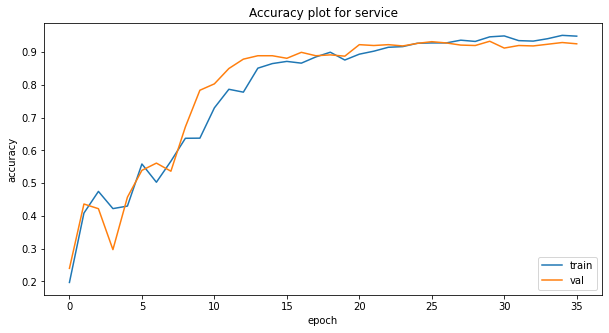

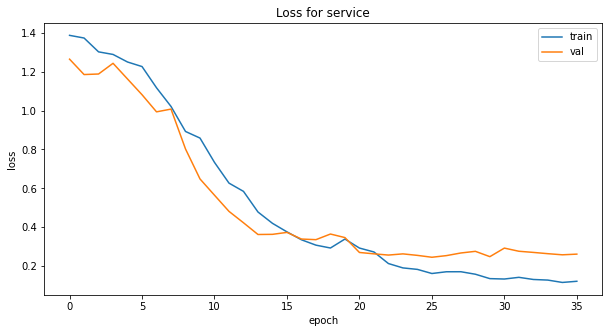

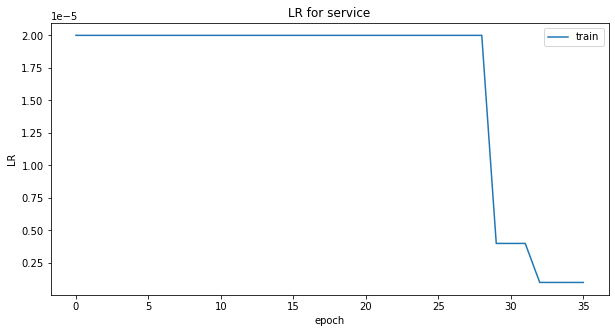

5/5 [==============================] - 13s 2s/step
metrics for  service
              precision    recall  f1-score   support

    Negative       0.70      0.81      0.75        63
     Neutral       0.00      0.00      0.00         3
    Positive       0.80      0.93      0.86       101
        None       0.99      0.94      0.96       633

    accuracy                           0.93       800
   macro avg       0.62      0.67      0.64       800
weighted avg       0.94      0.93      0.93       800

{0: 3.6411483253588517, 1: 8.455555555555556, 2: 0.8777393310265282, 3: 0.40521831735889247}


- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training for aspect:  food
Epoch 1/50
15/15 [==============================] - 90s 855ms/step - loss: 1.3771 - accuracy: 0.2055 - val_loss: 1.3502 - val_accuracy: 0.2409
Epoch 2/50
15/15 [==============================] - 48s 210ms/step - loss: 1.4018 - accuracy: 0.3189 - val_loss: 1.2780 - val_accuracy: 0.4727
Epoch 3/50
15/15 [==============================] - 3s 208ms/step - loss: 1.3081 - accuracy: 0.4254 - val_loss: 1.2193 - val_accuracy: 0.4544
Epoch 4/50
15/15 [==============================] - 3s 208ms/step - loss: 1.2967 - accuracy: 0.4943 - val_loss: 1.0649 - val_accuracy: 0.6849
Epoch 5/50
15/15 [==============================] - 4s 257ms/step - loss: 1.1080 - accuracy: 0.6657 - val_loss: 0.8998 - val_accuracy: 0.7370
Epoch 6/50
15/15 [==============================] - 3s 209ms/step - loss: 1.0482 - accuracy: 0.7376 - val_loss: 0.7686 - val_accuracy: 0.7891
Epoch 7/50
15/15 [==============================] - 3s 210ms/step - loss: 0.9602 - accuracy: 0.7442 - val_loss: 0.6798 

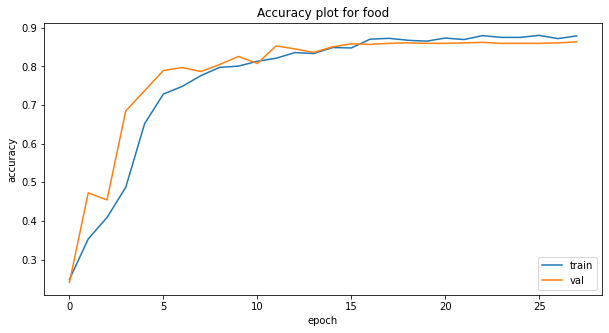

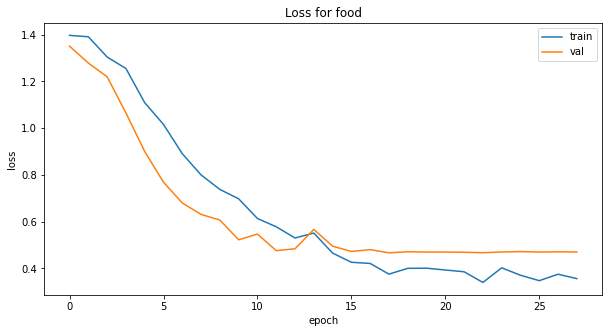

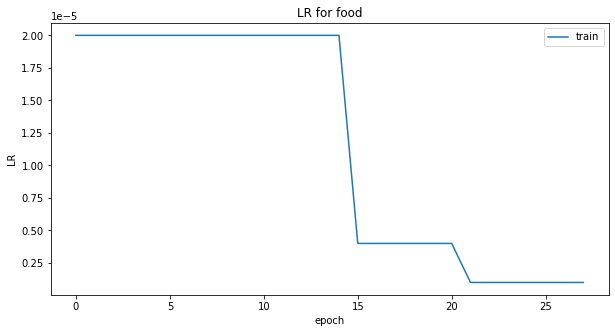

5/5 [==============================] - 13s 2s/step
metrics for  food
              precision    recall  f1-score   support

    Negative       0.64      0.74      0.68        69
     Neutral       0.26      0.52      0.34        31
    Positive       0.89      0.89      0.89       302
        None       0.97      0.87      0.92       398

    accuracy                           0.85       800
   macro avg       0.69      0.75      0.71       800
weighted avg       0.88      0.85      0.87       800

{0: 3.8266331658291457, 1: 2.1330532212885154, 2: 1.3921389396709323, 3: 0.3919197117858981}


- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training for aspect:  anecdotes/miscellaneous
Epoch 1/50
15/15 [==============================] - 91s 895ms/step - loss: 1.3963 - accuracy: 0.2837 - val_loss: 1.2104 - val_accuracy: 0.7005
Epoch 2/50
15/15 [==============================] - 48s 209ms/step - loss: 1.3664 - accuracy: 0.4659 - val_loss: 0.9879 - val_accuracy: 0.7305
Epoch 3/50
15/15 [==============================] - 3s 208ms/step - loss: 1.2457 - accuracy: 0.5545 - val_loss: 0.8014 - val_accuracy: 0.7643
Epoch 4/50
15/15 [==============================] - 3s 209ms/step - loss: 1.1731 - accuracy: 0.5960 - val_loss: 0.6997 - val_accuracy: 0.8008
Epoch 5/50
15/15 [==============================] - 3s 208ms/step - loss: 1.1369 - accuracy: 0.6106 - val_loss: 0.6237 - val_accuracy: 0.8333
Epoch 6/50
15/15 [==============================] - 3s 207ms/step - loss: 1.0477 - accuracy: 0.6500 - val_loss: 0.5407 - val_accuracy: 0.8424
Epoch 7/50
15/15 [==============================] - 3s 208ms/step - loss: 1.0101 - accuracy: 0.6695 

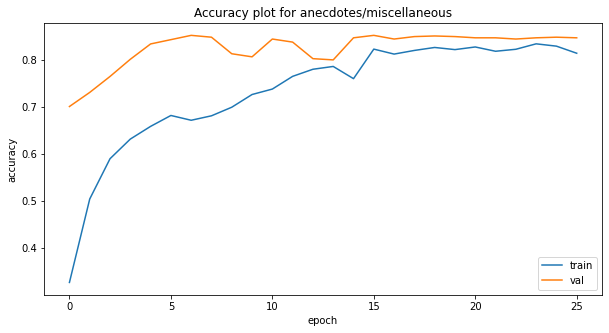

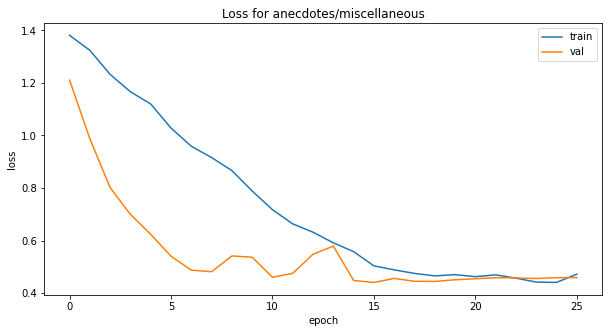

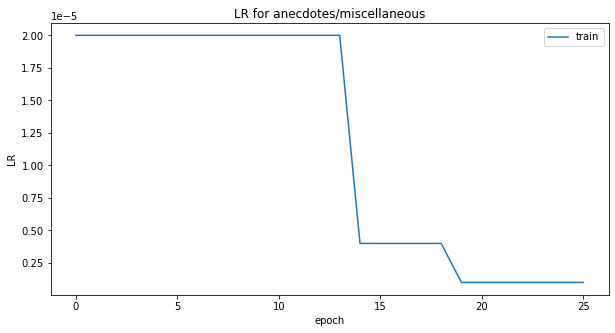

5/5 [==============================] - 13s 2s/step
metrics for  anecdotes/miscellaneous
              precision    recall  f1-score   support

    Negative       0.43      0.71      0.53        41
     Neutral       0.58      0.80      0.67        51
    Positive       0.79      0.79      0.79       127
        None       0.95      0.87      0.91       581

    accuracy                           0.85       800
   macro avg       0.69      0.79      0.73       800
weighted avg       0.87      0.85      0.86       800

{0: 6.6173913043478265, 1: 76.1, 2: 4.299435028248587, 3: 0.2775346462436178}


- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training for aspect:  price
Epoch 1/50
15/15 [==============================] - 93s 853ms/step - loss: 1.3524 - accuracy: 0.1458 - val_loss: 1.4118 - val_accuracy: 0.0430
Epoch 2/50
15/15 [==============================] - 49s 209ms/step - loss: 1.4736 - accuracy: 0.1953 - val_loss: 1.3998 - val_accuracy: 0.0417
Epoch 3/50
15/15 [==============================] - 3s 212ms/step - loss: 1.4146 - accuracy: 0.2599 - val_loss: 1.3698 - val_accuracy: 0.0690
Epoch 4/50
15/15 [==============================] - 3s 209ms/step - loss: 1.2710 - accuracy: 0.3187 - val_loss: 1.3290 - val_accuracy: 0.1615
Epoch 5/50
15/15 [==============================] - 3s 209ms/step - loss: 1.2361 - accuracy: 0.4065 - val_loss: 1.3101 - val_accuracy: 0.1393
Epoch 6/50
15/15 [==============================] - 3s 207ms/step - loss: 1.2558 - accuracy: 0.3718 - val_loss: 1.3817 - val_accuracy: 0.0495
Epoch 7/50
15/15 [==============================] - 3s 208ms/step - loss: 1.1366 - accuracy: 0.2819 - val_loss: 1.3443

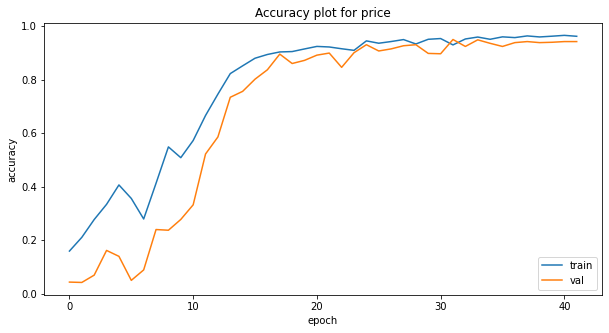

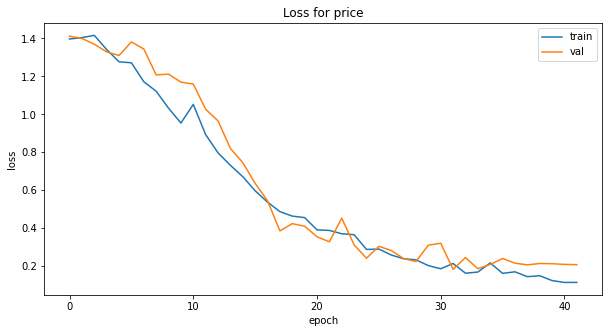

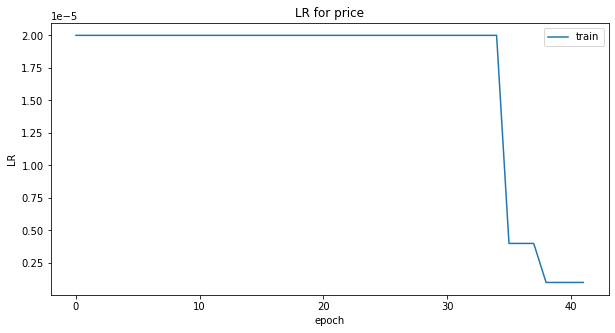

5/5 [==============================] - 13s 2s/step
metrics for  price
              precision    recall  f1-score   support

    Negative       0.50      0.89      0.64        28
     Neutral       0.00      0.00      0.00         1
    Positive       0.79      0.86      0.82        51
        None       1.00      0.96      0.98       720

    accuracy                           0.95       800
   macro avg       0.57      0.68      0.61       800
weighted avg       0.97      0.95      0.96       800

{0: 7.76530612244898, 1: 31.708333333333332, 2: 2.893536121673004, 3: 0.2861978187288454}


- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training for aspect:  ambience
Epoch 1/50
15/15 [==============================] - 92s 855ms/step - loss: 1.4013 - accuracy: 0.4108 - val_loss: 1.2054 - val_accuracy: 0.8359
Epoch 2/50
15/15 [==============================] - 48s 209ms/step - loss: 1.3093 - accuracy: 0.3501 - val_loss: 1.2931 - val_accuracy: 0.4987
Epoch 3/50
15/15 [==============================] - 3s 208ms/step - loss: 1.3369 - accuracy: 0.2880 - val_loss: 1.2643 - val_accuracy: 0.4818
Epoch 4/50
15/15 [==============================] - 3s 209ms/step - loss: 1.3751 - accuracy: 0.3422 - val_loss: 1.1337 - val_accuracy: 0.7096
Epoch 5/50
15/15 [==============================] - 3s 210ms/step - loss: 1.3126 - accuracy: 0.4008 - val_loss: 1.1677 - val_accuracy: 0.5482
Epoch 6/50
15/15 [==============================] - 3s 208ms/step - loss: 1.2782 - accuracy: 0.4327 - val_loss: 1.0068 - val_accuracy: 0.6706
Epoch 7/50
15/15 [==============================] - 3s 209ms/step - loss: 1.1301 - accuracy: 0.5746 - val_loss: 0.8

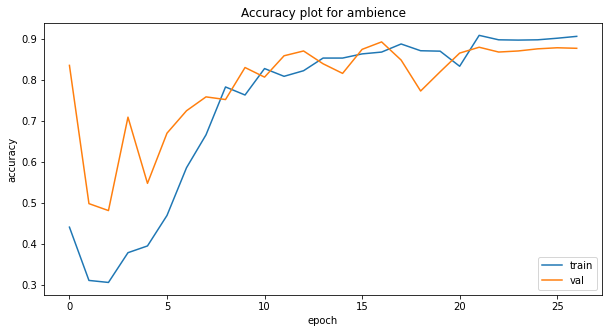

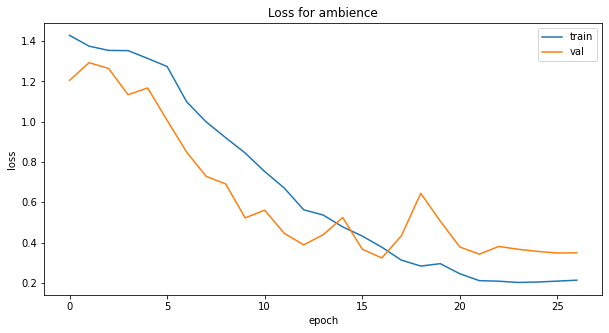

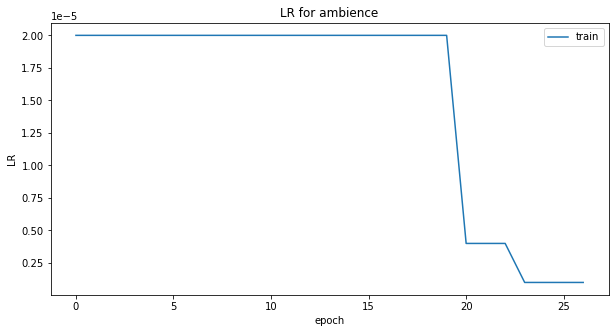

5/5 [==============================] - 13s 2s/step
metrics for  ambience
              precision    recall  f1-score   support

    Negative       0.34      0.67      0.45        21
     Neutral       0.00      0.00      0.00         8
    Positive       0.60      0.89      0.72        76
        None       0.98      0.91      0.94       695

    accuracy                           0.89       800
   macro avg       0.48      0.62      0.53       800
weighted avg       0.92      0.89      0.90       800



In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils import compute_class_weight
AUTO = tf.data.experimental.AUTOTUNE

dropout_arr = [0.4, 0.4, 0.4, 0.4, 0.4]

for i in range(5):
  aspect = ASPECT_LIBRARY[i]
  DROPOUT_VALUE = dropout_arr[i]

  print('------------------------ THIS IS RESULTS FOR ', aspect.upper(), '--------------------------')
  print()

  # retrieve data
  train = get_dataset(TRAIN_PATH, tokenizer, aspect)
  test = get_dataset(TEST_PATH, tokenizer, aspect)

  #declarations
  NUM_CLASSES = len(np.unique(train['polarity']))
  steps_per_epoch = len(train['polarity']) // BATCH_SIZE
  validation_steps= len(test['polarity']) // BATCH_SIZE

  # compute class weights
  class_weights = compute_class_weight('balanced', np.unique(train['polarity']), train['polarity'])
  d_class_weights = dict(enumerate(class_weights))
  print(d_class_weights)

  # get dataset
  train_dataset = (
    tf.data.Dataset
    .from_tensor_slices(({"input_ids": list(train['bert_single']), "attention_mask": list(train['bert_single_attention_mask']), "token_type_ids": list(train['bert_single_token_id'])},list(train['polarity'])))
    .batch(BATCH_SIZE)
    .repeat()
    .cache()
    .prefetch(AUTO)
  )

  valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices(({"input_ids": list(test['bert_single']), "attention_mask": list(test['bert_single_attention_mask']), "token_type_ids": list(test['bert_single_token_id'])}, list(test['polarity'])))
    .batch(BATCH_SIZE)
    .repeat()
    .cache()
    .prefetch(AUTO)
  )

  with strategy.scope():
    model = TFBertForSequenceClassification.from_pretrained(BERT_PRETRAINED_NAME, hidden_dropout_prob=DROPOUT_VALUE, num_labels=NUM_CLASSES)
    callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #tf.nn.sparse_softmax_cross_entropy_with_logits 
                      optimizer= tf.keras.optimizers.Adam(learning_rate=LR,epsilon=1e-08),
                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])


    # tpu
    print('training for aspect: ', aspect)
    hist = model.fit(
      train_dataset,
      steps_per_epoch=steps_per_epoch,
      epochs=EPOCH,
      class_weight=d_class_weights,
      # batch_size=batch_size,
      shuffle=True,
      # validation_split=0.2,
      validation_data=valid_dataset,
      validation_steps=validation_steps,
      callbacks=[reduce_lr, callback]
    )

  #validation
  plt.figure(figsize=(10,5))
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Accuracy plot for %s' %aspect)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='lower right')
  plt.show()

  plt.figure(figsize=(10,5))
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Loss for %s' %aspect)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

  plt.figure(figsize=(10,5))
  plt.plot(hist.history['lr'])
  plt.title('LR for %s' %aspect)
  plt.ylabel('LR')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

  target_names = ['Negative', 'Neutral', 'Positive', 'None'] if NUM_CLASSES == 4 else ['Negative', 'Neutral', 'Positive', 'Conflicts', 'None']

  test_dataset = (
        tf.data.Dataset
        .from_tensor_slices(({"input_ids": list(test['bert_single']), "attention_mask": list(test['bert_single_attention_mask']), "token_type_ids": list(test['bert_single_token_id'])}))
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
      )

  predictions = model.predict(test_dataset, verbose=1)
  predictions = tf.nn.softmax(tf.constant(predictions)[0])
  y_pred_argmax = np.argmax(tf.constant(predictions), axis=1)#tf.math.argmax(y_pred, axis=1)
  final_y_test[aspect] = list(test['polarity'])
  final_y_predict[aspect] =  list(y_pred_argmax)
  print("metrics for ", aspect)
  print(metrics.classification_report(list(test['polarity']), y_pred_argmax, target_names=target_names))





In [ ]:
f_y_true = []
f_y_pred = []

for k in final_y_test:
  f_y_true = f_y_true + final_y_test[k]
  f_y_pred = f_y_pred + final_y_predict[k]

print("final metrics for bert-single")
print(metrics.classification_report(list(f_y_true), f_y_pred, target_names=target_names))

final metrics for bert-single
              precision    recall  f1-score   support

    Negative       0.54      0.77      0.64       222
     Neutral       0.40      0.61      0.48        94
    Positive       0.80      0.87      0.84       657
        None       0.98      0.92      0.95      3027

    accuracy                           0.89      4000
   macro avg       0.68      0.79      0.73      4000
weighted avg       0.91      0.89      0.90      4000



# Original Semeval dataset

It involves none, negative, neutral, positive, conflict

In [ ]:
BERT_PRETRAINED_NAME = 'bert-base-uncased'
MAX_SEQ_LEN = 128
TRAIN_PATH='/path/to/BERT-ABSA/datasets/json_with_conflict/Restaurants_Original_Train.json'
TEST_PATH='/path/to/BERT-ABSA/datasets/json_with_conflict/Restaurants_Original_Test.json'
BERT_PRETRAINED_NAME = 'bert-base-uncased'
ASPECT_LIBRARY = ["service", "food", "anecdotes/miscellaneous", "price", "ambience" ]
EPOCH = 50
LR = 2e-5
BATCH_SIZE = 24 * strategy.num_replicas_in_sync
tokenizer = Tokeniser(MAX_SEQ_LEN)

In [ ]:
final_y_predict = {}
final_y_test = {}

In [ ]:
for predict in final_y_predict:
  print(predict)

{0: 2.7926605504587156, 1: 30.44, 2: 1.8790123456790124, 3: 17.394285714285715, 4: 0.24879444217409072}


- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training for aspect:  service
Epoch 1/50
15/15 [==============================] - 92s 882ms/step - loss: 1.6111 - accuracy: 0.0957 - val_loss: 1.5956 - val_accuracy: 0.0938
Epoch 2/50
15/15 [==============================] - 50s 212ms/step - loss: 1.5791 - accuracy: 0.1964 - val_loss: 1.4943 - val_accuracy: 0.2174
Epoch 3/50
15/15 [==============================] - 3s 211ms/step - loss: 1.4479 - accuracy: 0.3173 - val_loss: 1.3852 - val_accuracy: 0.2773
Epoch 4/50
15/15 [==============================] - 3s 211ms/step - loss: 1.3938 - accuracy: 0.3790 - val_loss: 1.3221 - val_accuracy: 0.3359
Epoch 5/50
15/15 [==============================] - 3s 212ms/step - loss: 1.2576 - accuracy: 0.4733 - val_loss: 1.0762 - val_accuracy: 0.5846
Epoch 6/50
15/15 [==============================] - 3s 214ms/step - loss: 1.0168 - accuracy: 0.6088 - val_loss: 0.9243 - val_accuracy: 0.7096
Epoch 7/50
15/15 [==============================] - 3s 214ms/step - loss: 0.8289 - accuracy: 0.7102 - val_loss: 0.79

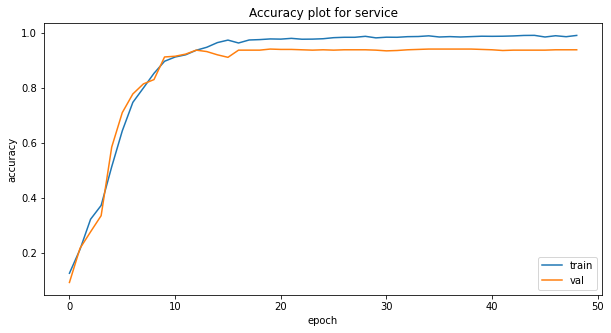

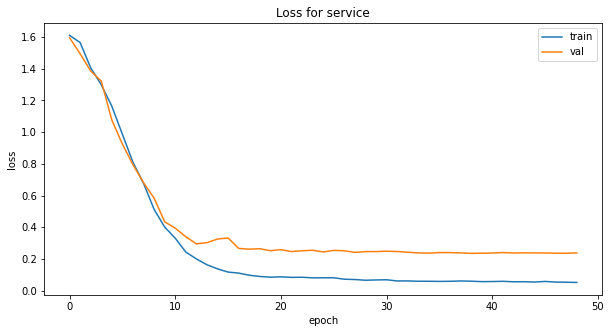

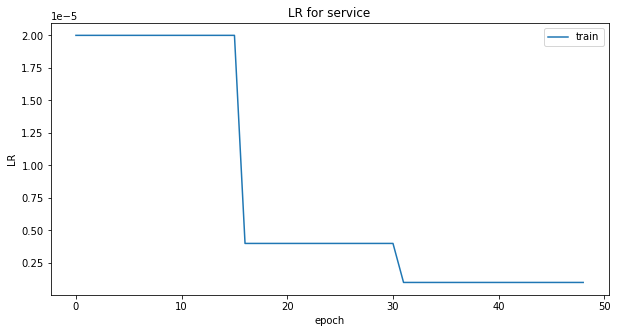

5/5 [==============================] - 14s 2s/step
metrics for  service
              precision    recall  f1-score   support

    Negative       0.75      0.79      0.77        63
     Neutral       0.00      0.00      0.00         3
    Positive       0.85      0.94      0.89       101
   Conflicts       0.38      0.60      0.46         5
        None       0.98      0.96      0.97       628

    accuracy                           0.94       800
   macro avg       0.59      0.66      0.62       800
weighted avg       0.94      0.94      0.94       800

{0: 2.9129186602870814, 1: 6.764444444444444, 2: 0.7021914648212226, 3: 9.086567164179105, 4: 0.33616786305908336}


- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training for aspect:  food
Epoch 1/50
15/15 [==============================] - 95s 891ms/step - loss: 1.6154 - accuracy: 0.0891 - val_loss: 1.5693 - val_accuracy: 0.2708
Epoch 2/50
15/15 [==============================] - 49s 213ms/step - loss: 1.5228 - accuracy: 0.3132 - val_loss: 1.3811 - val_accuracy: 0.5846
Epoch 3/50
15/15 [==============================] - 3s 212ms/step - loss: 1.3820 - accuracy: 0.6365 - val_loss: 1.0253 - val_accuracy: 0.7826
Epoch 4/50
15/15 [==============================] - 3s 212ms/step - loss: 1.1924 - accuracy: 0.7717 - val_loss: 0.7687 - val_accuracy: 0.8320
Epoch 5/50
15/15 [==============================] - 3s 213ms/step - loss: 0.9351 - accuracy: 0.8182 - val_loss: 0.6035 - val_accuracy: 0.8490
Epoch 6/50
15/15 [==============================] - 3s 213ms/step - loss: 0.7695 - accuracy: 0.8456 - val_loss: 0.5077 - val_accuracy: 0.8607
Epoch 7/50
15/15 [==============================] - 3s 215ms/step - loss: 0.6468 - accuracy: 0.8731 - val_loss: 0.4523 

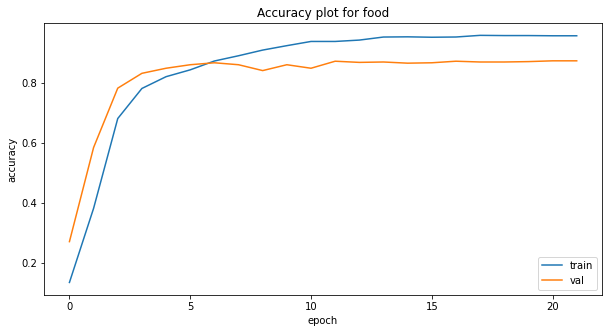

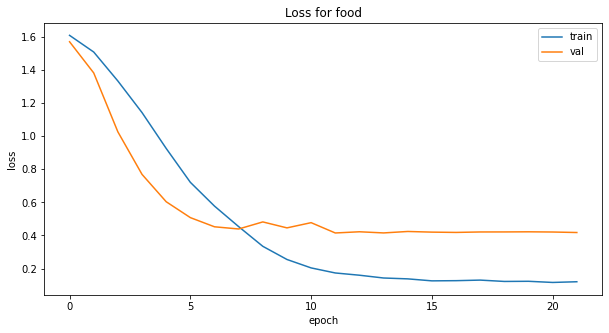

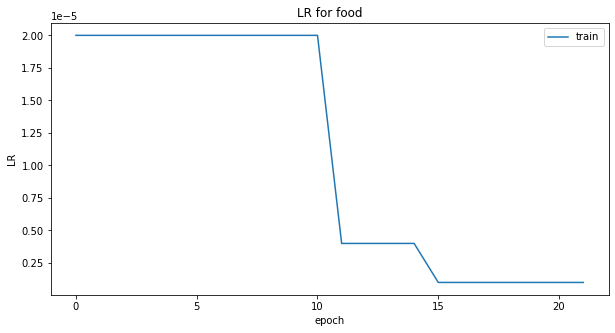

5/5 [==============================] - 14s 2s/step
metrics for  food
              precision    recall  f1-score   support

    Negative       0.70      0.68      0.69        69
     Neutral       0.36      0.52      0.43        31
    Positive       0.88      0.90      0.89       302
   Conflicts       0.62      0.31      0.42        16
        None       0.95      0.93      0.94       382

    accuracy                           0.87       800
   macro avg       0.70      0.67      0.67       800
weighted avg       0.87      0.87      0.87       800

{0: 3.0613065326633166, 1: 1.7064425770308123, 2: 1.113711151736746, 3: 20.30666666666667, 4: 0.3184526921066388}


- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training for aspect:  anecdotes/miscellaneous
Epoch 1/50
15/15 [==============================] - 95s 861ms/step - loss: 1.5424 - accuracy: 0.3134 - val_loss: 1.4550 - val_accuracy: 0.6224
Epoch 2/50
15/15 [==============================] - 49s 210ms/step - loss: 1.6221 - accuracy: 0.4369 - val_loss: 1.5068 - val_accuracy: 0.2969
Epoch 3/50
15/15 [==============================] - 3s 208ms/step - loss: 1.4592 - accuracy: 0.3381 - val_loss: 1.3906 - val_accuracy: 0.5013
Epoch 4/50
15/15 [==============================] - 3s 210ms/step - loss: 1.3668 - accuracy: 0.4701 - val_loss: 1.2317 - val_accuracy: 0.6055
Epoch 5/50
15/15 [==============================] - 3s 211ms/step - loss: 1.2570 - accuracy: 0.5226 - val_loss: 0.9828 - val_accuracy: 0.7578
Epoch 6/50
15/15 [==============================] - 3s 209ms/step - loss: 1.1079 - accuracy: 0.6263 - val_loss: 0.8525 - val_accuracy: 0.7695
Epoch 7/50
15/15 [==============================] - 3s 210ms/step - loss: 0.9691 - accuracy: 0.6787 

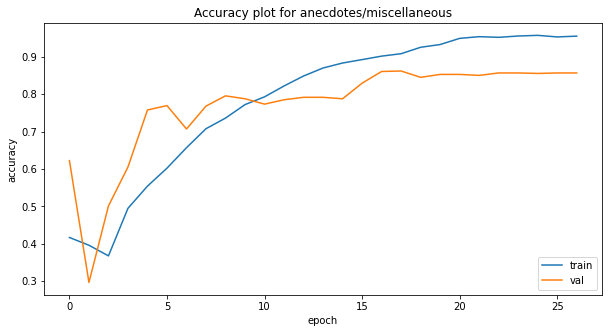

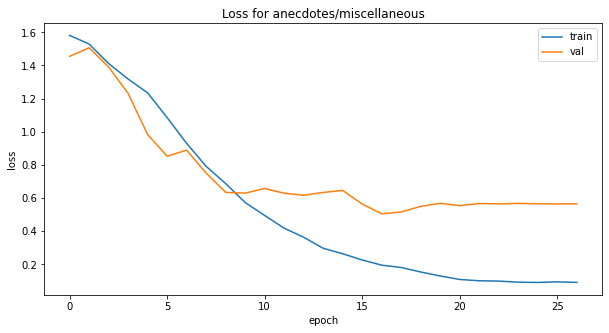

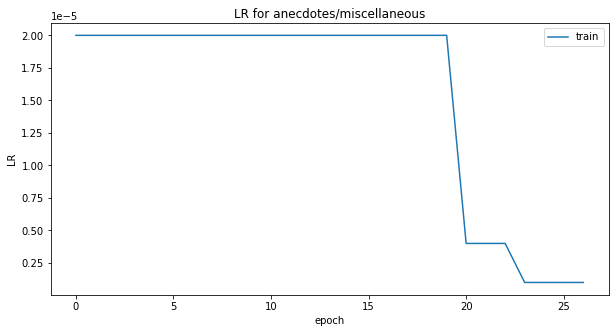

5/5 [==============================] - 13s 2s/step
metrics for  anecdotes/miscellaneous
              precision    recall  f1-score   support

    Negative       0.53      0.49      0.51        41
     Neutral       0.58      0.76      0.66        51
    Positive       0.77      0.80      0.79       127
   Conflicts       1.00      0.07      0.12        15
        None       0.93      0.92      0.93       566

    accuracy                           0.86       800
   macro avg       0.76      0.61      0.60       800
weighted avg       0.86      0.86      0.85       800

{0: 5.293913043478261, 1: 60.88, 2: 3.43954802259887, 3: 35.811764705882354, 4: 0.22341284403669726}


- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training for aspect:  price
Epoch 1/50
15/15 [==============================] - 94s 866ms/step - loss: 1.5190 - accuracy: 0.2280 - val_loss: 1.5789 - val_accuracy: 0.2370
Epoch 2/50
15/15 [==============================] - 50s 213ms/step - loss: 1.5875 - accuracy: 0.2405 - val_loss: 1.4977 - val_accuracy: 0.3281
Epoch 3/50
15/15 [==============================] - 3s 212ms/step - loss: 1.4864 - accuracy: 0.3777 - val_loss: 1.4291 - val_accuracy: 0.4023
Epoch 4/50
15/15 [==============================] - 3s 210ms/step - loss: 1.3187 - accuracy: 0.4792 - val_loss: 1.1991 - val_accuracy: 0.8229
Epoch 5/50
15/15 [==============================] - 3s 210ms/step - loss: 1.1640 - accuracy: 0.7870 - val_loss: 1.0584 - val_accuracy: 0.8802
Epoch 6/50
15/15 [==============================] - 3s 212ms/step - loss: 1.1125 - accuracy: 0.7877 - val_loss: 0.7998 - val_accuracy: 0.9141
Epoch 7/50
15/15 [==============================] - 3s 211ms/step - loss: 0.8992 - accuracy: 0.9009 - val_loss: 0.7318

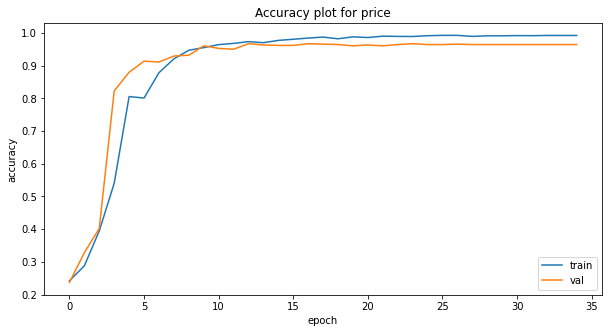

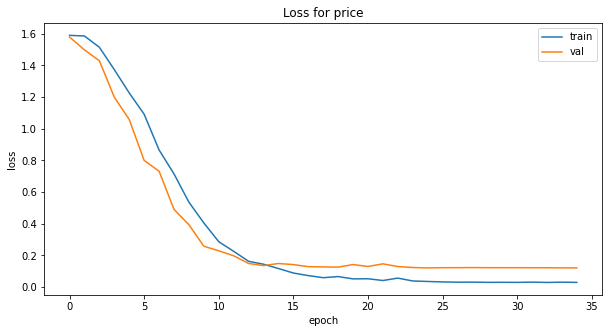

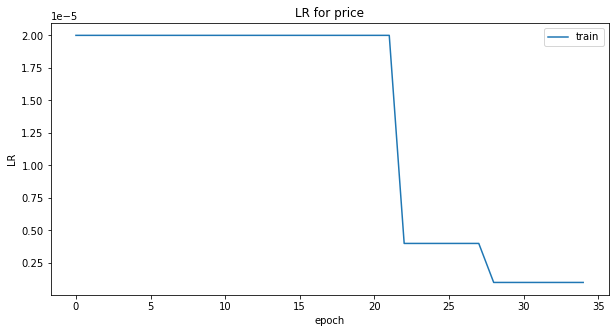

5/5 [==============================] - 13s 2s/step
metrics for  price
              precision    recall  f1-score   support

    Negative       0.77      0.71      0.74        28
     Neutral       0.00      0.00      0.00         1
    Positive       0.76      0.82      0.79        51
   Conflicts       0.00      0.00      0.00         3
        None       0.99      0.99      0.99       717

    accuracy                           0.96       800
   macro avg       0.50      0.51      0.50       800
weighted avg       0.96      0.96      0.96       800



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{0: 6.2122448979591836, 1: 25.366666666666667, 2: 2.314828897338403, 3: 12.953191489361702, 4: 0.2330781010719755}


- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


training for aspect:  ambience
Epoch 1/50
15/15 [==============================] - 92s 914ms/step - loss: 1.5779 - accuracy: 0.2934 - val_loss: 1.6906 - val_accuracy: 0.1328
Epoch 2/50
15/15 [==============================] - 50s 211ms/step - loss: 1.4442 - accuracy: 0.4486 - val_loss: 1.6661 - val_accuracy: 0.2982
Epoch 3/50
15/15 [==============================] - 3s 210ms/step - loss: 1.4047 - accuracy: 0.5559 - val_loss: 1.2696 - val_accuracy: 0.6693
Epoch 4/50
15/15 [==============================] - 3s 210ms/step - loss: 1.3402 - accuracy: 0.7068 - val_loss: 1.1165 - val_accuracy: 0.7513
Epoch 5/50
15/15 [==============================] - 3s 212ms/step - loss: 1.1984 - accuracy: 0.8019 - val_loss: 1.1811 - val_accuracy: 0.6771
Epoch 6/50
15/15 [==============================] - 3s 213ms/step - loss: 1.0908 - accuracy: 0.7790 - val_loss: 0.8605 - val_accuracy: 0.8073
Epoch 7/50
15/15 [==============================] - 3s 212ms/step - loss: 0.8898 - accuracy: 0.8487 - val_loss: 0.8

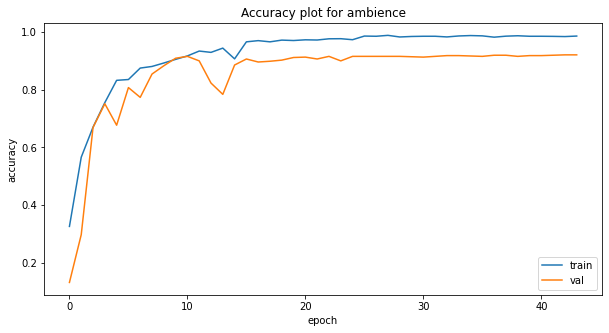

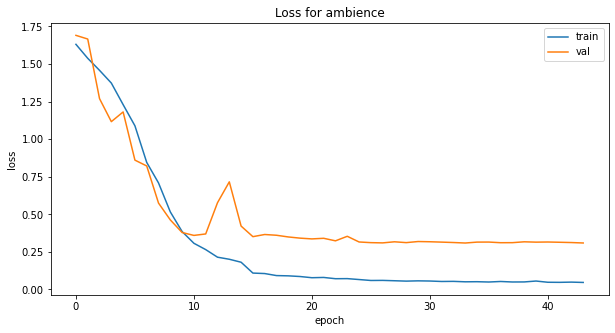

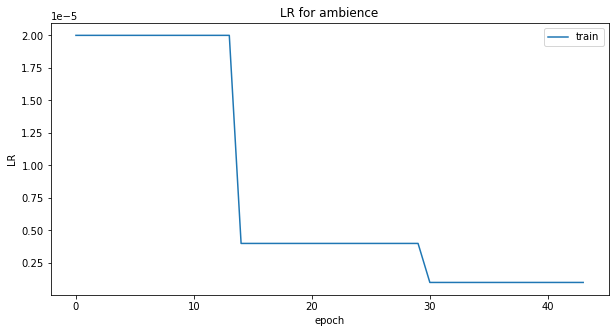

5/5 [==============================] - 14s 2s/step
metrics for  ambience
              precision    recall  f1-score   support

    Negative       0.41      0.57      0.48        21
     Neutral       0.25      0.12      0.17         8
    Positive       0.69      0.80      0.74        76
   Conflicts       0.43      0.23      0.30        13
        None       0.98      0.96      0.97       682

    accuracy                           0.92       800
   macro avg       0.55      0.54      0.53       800
weighted avg       0.92      0.92      0.92       800



In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils import compute_class_weight
AUTO = tf.data.experimental.AUTOTUNE

dropout_arr = [0.2, 0.2, 0.2, 0.2, 0.2]

for i in range(5):
  aspect = ASPECT_LIBRARY[i]
  DROPOUT_VALUE = dropout_arr[i]

  print('------------------------ THIS IS RESULTS FOR ', aspect.upper(), '--------------------------')
  print()

  # retrieve data
  train = get_dataset(TRAIN_PATH, tokenizer, aspect)
  test = get_dataset(TEST_PATH, tokenizer, aspect)

  #declarations
  NUM_CLASSES = len(np.unique(train['polarity']))
  steps_per_epoch = len(train['polarity']) // BATCH_SIZE
  validation_steps= len(test['polarity']) // BATCH_SIZE

  # compute class weights
  class_weights = compute_class_weight('balanced', np.unique(train['polarity']), train['polarity'])
  d_class_weights = dict(enumerate(class_weights))
  print(d_class_weights)

  # get dataset
  train_dataset = (
    tf.data.Dataset
    .from_tensor_slices(({"input_ids": list(train['bert_single']), "attention_mask": list(train['bert_single_attention_mask']), "token_type_ids": list(train['bert_single_token_id'])},list(train['polarity'])))
    .batch(BATCH_SIZE)
    .repeat()
    .cache()
    .prefetch(AUTO)
  )

  valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices(({"input_ids": list(test['bert_single']), "attention_mask": list(test['bert_single_attention_mask']), "token_type_ids": list(test['bert_single_token_id'])}, list(test['polarity'])))
    .batch(BATCH_SIZE)
    .repeat()
    .cache()
    .prefetch(AUTO)
  )

  with strategy.scope():
    model = TFBertForSequenceClassification.from_pretrained(BERT_PRETRAINED_NAME, hidden_dropout_prob=DROPOUT_VALUE, num_labels=NUM_CLASSES)
    callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

    model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #tf.nn.sparse_softmax_cross_entropy_with_logits 
                      optimizer= tf.keras.optimizers.Adam(learning_rate=LR,epsilon=1e-08),
                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])


    # tpu
    print('training for aspect: ', aspect)
    hist = model.fit(
      train_dataset,
      steps_per_epoch=steps_per_epoch,
      epochs=EPOCH,
      class_weight=d_class_weights,
      # batch_size=batch_size,
      shuffle=True,
      # validation_split=0.2,
      validation_data=valid_dataset,
      validation_steps=validation_steps,
      callbacks=[reduce_lr, callback]
    )

  #validation
  plt.figure(figsize=(10,5))
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('Accuracy plot for %s' %aspect)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='lower right')
  plt.show()

  plt.figure(figsize=(10,5))
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Loss for %s' %aspect)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

  plt.figure(figsize=(10,5))
  plt.plot(hist.history['lr'])
  plt.title('LR for %s' %aspect)
  plt.ylabel('LR')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

  target_names = ['Negative', 'Neutral', 'Positive', 'None'] if NUM_CLASSES == 4 else ['Negative', 'Neutral', 'Positive', 'Conflicts', 'None']

  test_dataset = (
        tf.data.Dataset
        .from_tensor_slices(({"input_ids": list(test['bert_single']), "attention_mask": list(test['bert_single_attention_mask']), "token_type_ids": list(test['bert_single_token_id'])}))
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
      )

  predictions = model.predict(test_dataset, verbose=1)
  predictions = tf.nn.softmax(tf.constant(predictions)[0])
  y_pred_argmax = np.argmax(tf.constant(predictions), axis=1)#tf.math.argmax(y_pred, axis=1)
  final_y_test[aspect] = list(test['polarity'])
  final_y_predict[aspect] =  list(y_pred_argmax)
  print("metrics for ", aspect)
  print(metrics.classification_report(list(test['polarity']), y_pred_argmax, target_names=target_names))





In [ ]:
f_y_true = []
f_y_pred = []

for k in final_y_test:
  f_y_true = f_y_true + final_y_test[k]
  f_y_pred = f_y_pred + final_y_predict[k]

print("final metrics for bert-single")
print(metrics.classification_report(list(f_y_true), f_y_pred, target_names=target_names))

final metrics for bert-single
              precision    recall  f1-score   support

    Negative       0.66      0.67      0.66       222
     Neutral       0.48      0.60      0.53        94
    Positive       0.82      0.87      0.84       657
   Conflicts       0.50      0.23      0.32        52
        None       0.97      0.96      0.96      2975

    accuracy                           0.91      4000
   macro avg       0.68      0.66      0.66      4000
weighted avg       0.91      0.91      0.91      4000



# These are the results recorded for the research

## Bert-Single with conflict

In [ ]:
f_y_true = []
f_y_pred = []

for k in final_y_test:
  f_y_true = f_y_true + final_y_test[k]
  f_y_pred = f_y_pred + final_y_predict[k]

print("final metrics for bert-single")
print(metrics.classification_report(list(f_y_true), f_y_pred, target_names=target_names))

final metrics for bert-single
              precision    recall  f1-score   support

    Negative       0.56      0.72      0.63       222
     Neutral       0.50      0.62      0.55        94
    Positive       0.83      0.84      0.83       657
   Conflicts       0.29      0.35      0.32        52
        None       0.97      0.94      0.95      2975

    accuracy                           0.89      4000
   macro avg       0.63      0.69      0.66      4000
weighted avg       0.90      0.89      0.90      4000



## Bert-Single without conflict

In [ ]:
f_y_true = []
f_y_pred = []

for k in final_y_test:
  f_y_true = f_y_true + final_y_test[k]
  f_y_pred = f_y_pred + final_y_predict[k]

print("final metrics for bert-single")
print(metrics.classification_report(list(f_y_true), f_y_pred, target_names=target_names))

final metrics for bert-single
              precision    recall  f1-score   support

    Negative       0.61      0.74      0.67       222
     Neutral       0.40      0.55      0.47        94
    Positive       0.79      0.89      0.84       657
        None       0.98      0.93      0.95      3027

    accuracy                           0.90      4000
   macro avg       0.70      0.78      0.73      4000
weighted avg       0.91      0.90      0.90      4000

